In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

list_100B_20T = pd.read_csv('all_tickers_100B_20T.csv')
list_ticker = list_100B_20T['ticker'].unique().tolist()
print(len(list_ticker))

# Step 2: Remove tickers containing "."
list_ticker = [ticker for ticker in list_ticker if "." not in ticker]
print(len(list_ticker))

# Step 1: Fetch Data
start_date = "2010-01-01"
end_date = "2024-12-31"
stock_data = yf.download(list_ticker, start=start_date, end=end_date)["Close"]

# Step 3: Filter out tickers that do not have data before 2015-01-01
valid_tickers = [ticker for ticker in stock_data.columns if stock_data[ticker].loc[:'2015-01-01'].notna().any()]

# Step 4: Filter the stock data to keep only valid tickers
stock_data = stock_data[valid_tickers]

# Step 5: Prepare data - Calculate daily returns
stock_returns = stock_data.pct_change().dropna()

[                       0%                       ]

384
176


[*********************100%***********************]  176 of 176 completed
/tmp/ipykernel_35361/613977033.py:29: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = stock_data.pct_change().dropna()


In [17]:
stock_returns.head()

Ticker,AAPL,ABALX,ABBV,ABT,ADBE,ADI,ADP,AEGFX,AFIFX,AGG,...,VTSAX,VTV,VUG,VWELX,VWENX,VXUS,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-09,0.016001,0.000786,-0.022868,0.001997,0.000299,0.049725,0.004899,0.000790,0.001487,-0.000919,...,0.001624,0.000617,0.000916,0.001003,0.001016,0.000731,0.003035,0.010196,-0.002590,-0.000787
2014-06-10,0.005870,0.000393,0.002414,0.009968,0.000448,0.008679,-0.007500,0.002170,0.000742,-0.001470,...,-0.000608,0.000741,-0.000915,-0.000251,-0.000290,-0.000730,-0.001009,0.001523,-0.005064,-0.000591
2014-06-11,-0.004138,-0.002749,0.004818,-0.013076,0.007467,-0.002868,-0.004815,-0.003346,-0.002782,0.000736,...,-0.003447,-0.004809,-0.001018,-0.002256,-0.002177,-0.003656,-0.003029,-0.006655,-0.006004,0.004829
2014-06-12,-0.016727,-0.004546,-0.010511,-0.004750,-0.013341,-0.003415,-0.003693,-0.001185,-0.006227,0.001932,...,-0.006714,-0.006442,-0.008762,-0.003015,-0.003345,-0.000367,-0.006684,-0.010145,-0.005646,-0.002844
2014-06-13,-0.010944,0.001588,0.009318,-0.000503,0.003906,0.003247,0.007157,-0.001977,0.001876,-0.000276,...,0.003277,0.004489,0.002158,0.002016,0.002481,0.001284,0.002855,0.003674,-0.005942,0.009739


In [18]:
# Import FF Factors
FF_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV')
FF_df['Date'] = pd.to_datetime(FF_df['Date'], format='%Y%m%d')
FF_df['Mkt-RF'] = FF_df['Mkt-RF']/100
FF_df['SMB'] = FF_df['SMB']/100
FF_df['HML'] = FF_df['HML']/100
FF_df['RF'] = FF_df['RF']/100


# Merge the FF Factors to Stocks
stock_returns = stock_returns.merge(FF_df, on = 'Date', how = 'inner')

# print minimal and maximum dates
print(stock_returns['Date'].min(), stock_returns['Date'].max())

2014-06-09 00:00:00 2024-11-29 00:00:00


In [19]:
# List of columns to exclude
columns_to_exclude = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

# Get all columns and exclude the specified ones
stock_list = [col for col in stock_returns.columns if col not in columns_to_exclude]

# Preview the filtered column names
print(stock_list)

['AAPL', 'ABALX', 'ABBV', 'ABT', 'ADBE', 'ADI', 'ADP', 'AEGFX', 'AFIFX', 'AGG', 'AGTHX', 'AICFX', 'AMAT', 'AMD', 'AMECX', 'AMGN', 'AMZN', 'ANET', 'ANWPX', 'AVGO', 'AXP', 'BA', 'BAC', 'BALFX', 'BKNG', 'BLK', 'BMY', 'BMYMP', 'BND', 'BRK-A', 'BRK-B', 'BSX', 'BX', 'C', 'CAT', 'CGFAX', 'CIBFX', 'CMCSA', 'COP', 'COST', 'CRM', 'CSCO', 'CVX', 'CWGFX', 'DE', 'DHR', 'DIS', 'EP-PC', 'FCNTX', 'FI', 'FSKAX', 'FXAIX', 'GE', 'GFACX', 'GFAFX', 'GILD', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'IEFA', 'IFAFX', 'INTU', 'ISRG', 'IVV', 'IWF', 'JLGMX', 'JLGRX', 'JNJ', 'JPM', 'KKR', 'KLAC', 'KO', 'LLY', 'LMT', 'LOW', 'LRCX', 'MA', 'MCD', 'MER-PK', 'META', 'MMC', 'MRK', 'MRVL', 'MS', 'MSFT', 'MU', 'NEE', 'NFLX', 'NKE', 'NOW', 'NPFFX', 'NVDA', 'ORCL', 'PANW', 'PEP', 'PFE', 'PG', 'PGR', 'PIMIX', 'PLD', 'PM', 'PONPX', 'QCOM', 'QQQ', 'RCIT', 'RERGX', 'RGAAX', 'RGABX', 'RGAGX', 'RTX', 'RWICX', 'SBUX', 'SCHW', 'SEEGX', 'SPGI', 'SPY', 'SYK', 'T', 'TJX', 'TMO', 'TMUS', 'TSLA', 'TXGE', 'TXN', 'UNH', 'UNP', 'UPS', 'V

In [20]:
# Three factor model
all_betas = []
for stock in stock_list:
    y = stock_returns[stock] - stock_returns['RF']
    x = stock_returns[['Mkt-RF', 'SMB', 'HML']]
    model = sm.OLS(y, x).fit()
    temp = {'ticker': stock,
            'MKT_excess_beta': model.params['Mkt-RF'],
            'SMB_beta': model.params['SMB'],
            'HML_beta': model.params['HML']}
    all_betas.append(temp)

all_beta_df = pd.DataFrame(all_betas)

# Bring market_cap, sector, industry info
all_beta_df = all_beta_df.merge(list_100B_20T[['ticker', 'name', 'market_cap', 'sector', 'industry']], on='ticker', how='left')

In [21]:
all_beta_df.head()

,ticker,MKT_excess_beta,SMB_beta,HML_beta,name,market_cap,sector,industry
0,AAPL,1.170131,-0.292769,-0.402993,Apple Inc.,3350143362000,Technology,Consumer Electronics
1,ABALX,0.560410,-0.053556,0.035180,American Funds American Balanced Fund Class A,236071026687,Financial Services,Asset Management
2,ABBV,0.690915,-0.244228,0.018632,AbbVie Inc.,300943942000,Healthcare,Drug Manufacturers - General
3,ABT,0.846834,-0.300191,-0.176078,Abbott Laboratories,216859533800,Healthcare,Medical - Devices
4,ADBE,1.244842,-0.219428,-0.702033,Adobe Inc.,189524832420,Technology,Software - Infrastructure


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

columns_for_clustering = ['MKT_excess_beta', 'SMB_beta', 'HML_beta']
X = all_beta_df[columns_for_clustering]

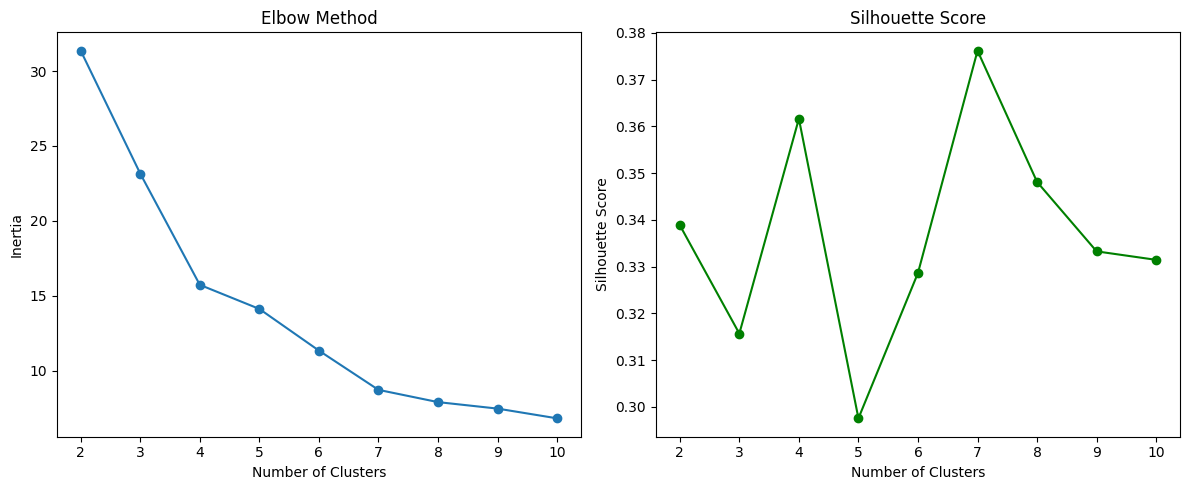

In [23]:
# Elbow Method
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 11)  # Test for 2 to 10 clusters

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=20).fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Inertia and Silhouette Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Elbow Method Plot (Inertia vs. Number of Clusters):
# Look for the "elbow," which is the point where the decrease in inertia slows down significantly. This suggests the optimal number of clusters.

# Silhouette Score Plot (Silhouette Score vs. Number of Clusters):
# The peak value of the Silhouette Score indicates the best number of clusters, as it represents the best separation and compactness of the clusters.

# Looks 6 is a good number of clusters

In [24]:
optimal_clusters = 4

# K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=20).fit(X)
X['Cluster'] = kmeans.labels_

all_beta_df['Cluster'] =  kmeans.labels_
cluster_analysis = all_beta_df.groupby('Cluster').agg(mean_MKT_excess_beta = ('MKT_excess_beta', 'mean'),
                                                      mean_SMB_beta= ('SMB_beta', 'mean'),
                                                      mean_HML_beta= ('HML_beta', 'mean'),
                                                      mean_market_cap= ('market_cap', 'mean'),
                                                      num_comp= ('name', 'count')
                                                      ).reset_index()

print("Cluster Analysis (Means and Record Counts):\n", cluster_analysis)

Cluster Analysis (Means and Record Counts):
    Cluster  mean_MKT_excess_beta  mean_SMB_beta  mean_HML_beta  \
0        0              0.463273      -0.163656       0.059764   
1        1              0.946083      -0.023588       0.053914   
2        2              1.142265       0.063156       0.829868   
3        3              1.238475      -0.014788      -0.482335   

   mean_market_cap  num_comp  
0     2.314268e+11        36  
1     3.001217e+11        82  
2     2.517836e+11        16  
3     7.763713e+11        33  


/tmp/ipykernel_35361/1458720576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = kmeans.labels_


In [25]:
# Distribution of sectors across clusters
sector_distribution = all_beta_df.groupby(['Cluster', 'sector']).size().reset_index(name='sector_count')

# Distribution of industries across clusters
industry_distribution = all_beta_df.groupby(['Cluster', 'industry']).size().reset_index(name='industry_count')

# Top 3 most frequent sectors per cluster
top_sectors = sector_distribution.groupby('Cluster').apply(lambda x: x.nlargest(3, 'sector_count')).reset_index(drop=True)

# Top 3 most frequent industries per cluster
top_industries = industry_distribution.groupby('Cluster').apply(lambda x: x.nlargest(3, 'industry_count')).reset_index(drop=True)

# Print the results
print("Top 3 Most Frequent Sectors per Cluster:\n", top_sectors)
print("\nTop 3 Most Frequent Industries per Cluster:\n", top_industries)


Top 3 Most Frequent Sectors per Cluster:
     Cluster                  sector  sector_count
0         0      Financial Services            14
1         0              Healthcare             8
2         0      Consumer Defensive             6
3         1      Financial Services            46
4         1              Healthcare             7
5         1       Consumer Cyclical             6
6         2      Financial Services             8
7         2             Industrials             5
8         2                  Energy             3
9         3              Technology            17
10        3      Financial Services             6
11        3  Communication Services             4

Top 3 Most Frequent Industries per Cluster:
     Cluster                        industry  industry_count
0         0    Drug Manufacturers - General               8
1         0                Asset Management               5
2         0       Asset Management - Income               5
3         1           

/tmp/ipykernel_35361/994630695.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_sectors = sector_distribution.groupby('Cluster').apply(lambda x: x.nlargest(3, 'sector_count')).reset_index(drop=True)
/tmp/ipykernel_35361/994630695.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_industries = industry_distribution.groupby('Cluster').apply(lambda x: x.nlargest(3, 'industry_count')).reset_index(d